This notebook is used to generate Figure 6 in the paper.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from depsurf import RenameType, Version


def count_rename(v: Version):
    result = {t: 0 for t in RenameType}
    total = 0

    for sym in v.img.func_groups.iter_symbols():
        total += 1
        if not sym.has_suffix:
            continue
        result[sym.rename_type] += 1

    return {
        **result,
        "Total": total,
        "GCC": v.img.gcc_version,
    }

In [3]:
from depsurf import VersionGroup
from utils import save_pkl
from typing import Dict

groups = [VersionGroup.REGULAR, VersionGroup.ARCH]

DataType = Dict[VersionGroup, Dict[Version, Dict[str, int]]]
data: DataType = {}
for group in groups:
    group_data = {}
    for version in group.versions:
        group_data[version] = count_rename(version)
    data[group] = group_data

save_pkl(data, "rename")

[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.4.0-21-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.8.0-22-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.10.0-19-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.13.0-16-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.15.0-20-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.18.0-10-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/5.0.0-13-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/5.3.0-18-generic-amd64.jsonl
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSur

In [4]:
import pandas as pd

from utils import load_pkl

data: "DataType" = load_pkl("rename")
pd.DataFrame(
    {
        (group, version): data[group][version]
        for group in data
        for version in data[group]
    }
).T

[ utils_pickle.py:18 ] INFO: Loding rename from /users/szhong/DepSurf/output/rename.pkl


isra constprop part  cold localalias   ≥2  Total     GCC
Regular 4.4.0-21-generic-amd64    577       198  522     0          1   64  38332   5.3.1
        4.8.0-22-generic-amd64    578       234  561     0          0   63  40324   6.2.0
        4.10.0-19-generic-amd64   589       251  575     0          0   59  41302   6.3.0
        4.13.0-16-generic-amd64   608       253  725     0          0   70  43091   7.2.0
        4.15.0-20-generic-amd64   628       258  760     0          0   65  44736   7.3.0
        4.18.0-10-generic-amd64   709       263  736  1875          0  161  48901   8.2.0
        5.0.0-13-generic-amd64    721       262  749  1910          0  157  49739   8.3.0
        5.3.0-18-generic-amd64    785       428  774  4357          0  334  54400   9.2.1
        5.4.0-26-generic-amd64    783       409  774  3228          0  247  54172   9.3.0
        5.8.0-25-generic-amd64    612       764  974  3628          0  372  59799  10.2.0
        5.11.0-16-generic-amd64   631       796  998  3834          0  395  62752  10.3.0
        5.13.0-19-generic-amd64   524       743  725  3835          0  314  61300  11.2.0
        5.15.0-25-generic-amd64   522       767  714  8098          0  561  66580  11.2.0
        5.19.0-21-generic-amd64   564       845  520  8541          0  531  68695  12.2.0
        6.2.0-20-generic-amd64    575       884  494  5735          0  446  66887  12.2.0
        6.5.0-9-generic-amd64     827       724  503  6026          0  451  69751  13.2.0
        6.8.0-31-generic-amd64    865       768  533  6591          0  469  73116  13.2.0
Arch    5.4.0-26-generic-arm64    992       324  815     0          0  114  53382   9.3.0
        5.4.0-26-generic-armhf      0       504  814     0          0    4  50848   9.3.0
        5.4.0-26-generic-ppc64el  591       293  674     0          0   74  45087   9.3.0
        5.4.0-24-generic-riscv64  514       204  635     0          0   50  38816   9.3.0

[ utils_pickle.py:18 ] INFO: Loding rename from /users/szhong/DepSurf/output/rename.pkl


[utils_matplotlib.py:82 ] INFO: Saved figure to /users/szhong/DepSurf/paper/figs/rename.pdf


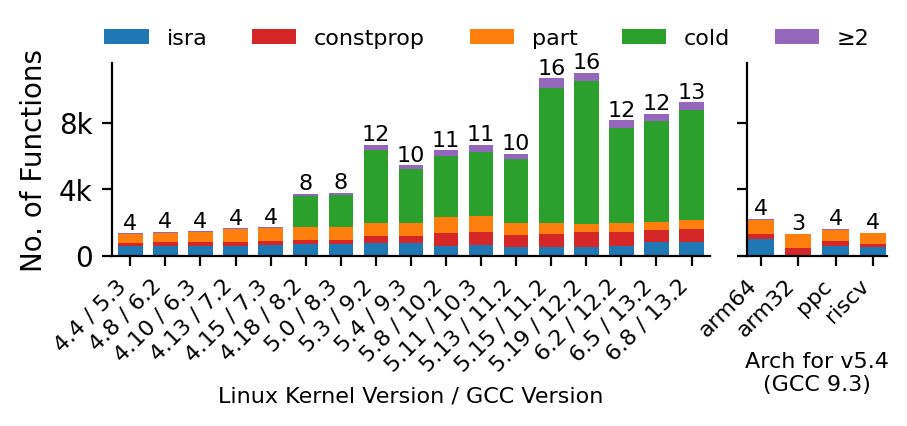

In [5]:
from depsurf import RenameType, VersionGroup
from utils import load_pkl, get_legend_handles_labels, save_fig, format_yticks, ARCH_NAMES
import matplotlib.pyplot as plt
import numpy as np

COLORS = {
    RenameType.ISRA: "C0",
    RenameType.PART: "C1",
    RenameType.COLD: "C2",
    RenameType.CONSTPROP: "C3",
    RenameType.MULTIPLE: "C4",
}

GROUPS = {
    VersionGroup.REGULAR: "Linux Kernel Version / GCC Version",
    VersionGroup.ARCH: "Arch for v5.4\n(GCC 9.3)",
}


data: "DataType" = load_pkl("rename")
fig, axs = plt.subplots(
    1,
    len(data),
    figsize=(5, 1.25),
    sharey=True,
    width_ratios=[len(v) for v in data.values()],
    gridspec_kw={"wspace": 0.1},
)


for group_idx, (ax, (group, group_data)) in enumerate(zip(axs, data.items())):
    for i, (version, version_data) in enumerate(group_data.items()):
        bottom = 0
        for k, v in version_data.items():
            if k not in COLORS:
                continue
            ax.bar(i, v, 0.7, label=k, bottom=bottom, color=COLORS[k])
            bottom += v

        # label total on top
        percentage = f"{bottom / version_data['Total'] * 100:.0f}"
        ax.text(i, bottom, percentage, ha="center", va="bottom", fontsize=8)

    labels = []
    for version, version_data in group_data.items():
        if group == VersionGroup.REGULAR:
            gcc_version = version_data["GCC"]
            gcc_version = version.img.gcc_version.rsplit(".", 1)[0]
            label = f"{version.short_version} / {gcc_version}"
        elif group == VersionGroup.ARCH:
            label = f"{ARCH_NAMES[version.arch]}"
        labels.append(label)
    ax.set_xticks(np.arange(len(labels)), labels)
    ax.set_xlabel(GROUPS[group], fontsize=8)
    ax.set_xticklabels(labels, fontsize=8, rotation=45, ha="right", va="top")
    format_yticks(ax)

    if group == VersionGroup.REGULAR:
        ax.set_ylabel("No. of Functions")

handles, labels = get_legend_handles_labels(fig)
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=8,
    # handlelength=1.5,
    # handletextpad=0.5,
    # columnspacing=1,
)
save_fig(fig, "rename")

4.15 -> 4.18:
- `-freorder-blocks-and-partition` enabed by default in GCC 8

- https://gcc.gnu.org/gcc-8/changes.html

5.0 -> 5.3:
- "Hot/cold partitioning is now more precise and aggressive." since GCC 9

- https://gcc.gnu.org/gcc-9/changes.html

5.13 -> 5.15:

- Non-static functions renamed e.g., `ipv6_local_rxpmtu`

5.19 -> 6.2: 

- `-falign-functions=16` added since Linux 6.2

- https://github.com/torvalds/linux/commit/c27cd083cfb9d392f304657ed00fcde1136704e7

- https://github.com/torvalds/linux/commit/d49a0626216b95cd4bf696f6acf55f39a16ab0bb